# Lab Assignment 1.2


## Important notes

**Submission deadline:**
** last lab session before Friday 29.10.2021**

**Points: 3+2+2+2+3+1bp = 13**

Please let us know about any problems with it - we will try to correct them quickly. Also, please do not hesitate to use GitHub’s pull requests to send us corrections!

## k-Nearest Neighbors

We will use the loaded Iris data describing iris flowers
and shows relations between their length and petal width for three
species (namely: setosa, versicolor, virginica).

For this exercise we will restrict our analysis to just two variables: **petal length** and **petal width**.

In [1]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')

In [2]:
!pip install icecream
from icecream import ic # for debug prints

In [3]:
import gc # garbage collector interface

In [4]:
# explicitly run garbage collection and release
gc.collect()

105

In [5]:
ic.disable() # disable debug prints

In [12]:
iris_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# Use read_csv to load the data. Make sure you get 150 examples!
iris_df = pd.read_csv(iris_url, header=None)

# Set the column names to
# 'sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target'
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Print the first 10 entries
iris_df.head(10)

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


time: 651 ms (started: 2021-10-26 20:14:23 +00:00)


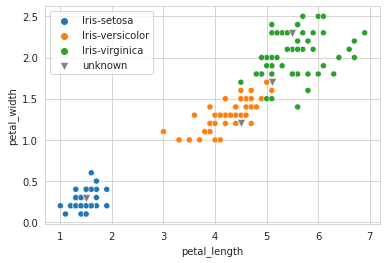

time: 392 ms (started: 2021-10-26 20:14:23 +00:00)


In [13]:
unknown_df = pd.DataFrame(
    [[1.5, 0.3, 'unknown'],
     [4.5, 1.2, 'unknown'],
     [5.1, 1.7, 'unknown'],
     [5.5, 2.3, 'unknown']],
     columns=['petal_length', 'petal_width', 'target'])

sns.scatterplot(x='petal_length', y='petal_width', hue='target', data=iris_df)
sns.scatterplot(x='petal_length', y='petal_width', color='gray', marker='v',
                label='unknown', s=70, data=unknown_df)

Based on these two features, it is easy to distinguish iris setosa from the two remaining species. Yet iris versicolor and virginica remain mixed together. 

Looking closely at the plot, we might estimate the species of the selected unknown irises (gray triangles). For three of them the answer seems obvious – they belong in uniformly-colored areas covered by one species only. Yet unknown iris flower in (5.1, 1.7) is troublesome – it lays on the boundary of versicolor and virginica clusters. We can assume, that its species is the one of the closest one to it, coming from the training set (and so having a label). 

K-Nearest Neighbors method (http://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) solves the classification problem, i.e. sets class labels (species in case of irises) of a previously unseen sample by choosing the most common class among the top k neighbors of the sample in question (for instance according to the Euclidean distance). Thus, the k-Nearest Neighbors algorithm works as follows. For each unlabeled sample x:
1. Find k nearest neighbors among the labeled samples.
2. Set the most common label among them as label of x.

## Problem 3 kNN Iris [3p]

### Implement the k-Nearest Neighbors algorithm [1p].

Take advantage of matrix calculus rather than using for loops. (Although you will earn 0.5 points, if you will use for loops, but still provide a good classifier)

**Tip:** What is computed by \begin{equation} \sqrt{(X - Y)^T (X - Y)} \end{equation} when both X and Y are vectors?

**Tip:** Try to use broadcasting (NumPy: http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) and built-ins sort, numpy.sort, numpy.argsort (sorting), scipy.stats.mode (choosing the most common element of the set).

In [134]:
def KNN(train_X, train_Y, test_X, ks, verbose=False):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    # Cast data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')
    #
    # TODO: fill in an efficient distance matrix computation
    # point_sub = train_X[np.newaxis,:,:] - test_X[:, np.newaxis, :]
    # _dists = np.sum(np.square(point_sub), axis=(-1)) # slooooow

    # embrace speeeeeed
    dists = np.sum(np.square(test_X)[:, np.newaxis, :], axis=-1) - 2.0 * test_X.dot(train_X.T) + np.sum(np.square(train_X), axis=-1)


    if verbose:
        print("Sorting... ", end='')
    
    # TODO: find closest training points
    # Hint: use argsort
    closest = np.argsort(dists, axis=-1)

    if verbose:
        print("Computing predictions...", end='')

    targets = train_Y[closest]

    for k in ks:
        predictions = targets[:, 0: k]
        predictions = sstats.mode(predictions, axis=1)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    return preds

time: 21.4 ms (started: 2021-10-25 22:23:57 +00:00)


In [14]:
# Now classify the 4 unknown points
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])

unknown_x = np.array(unknown_df[['petal_length', 'petal_width']])

# let's introduce new dimensions
# for the first dimension of result
# to be which unknown (1st, 2nd, 3rd or 4th) we subtracted
# from 2d point from iris_x array
KNN(iris_x, iris_y, unknown_x, [1, 3, 5, 7])

NameError: ignored

time: 15.7 ms (started: 2021-10-26 20:14:27 +00:00)


### Plot the Decision boundary [1p]


Use meshgrid to generate the points in the space spanned by data.
Then map the classes to numbers 0, 1, 2 and make a contour plot with the
decision boundary.

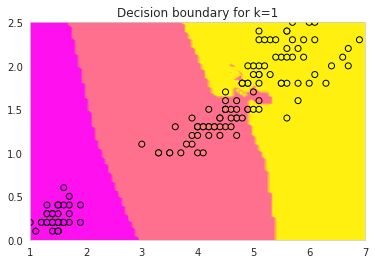

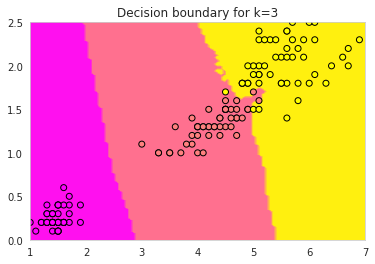

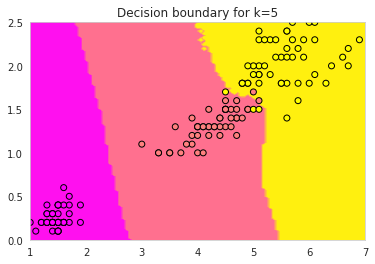

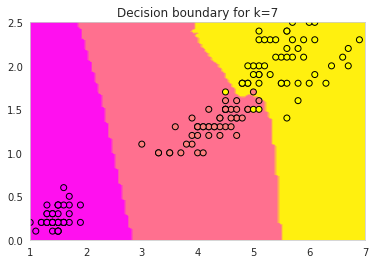

time: 3.19 s (started: 2021-10-25 22:26:24 +00:00)


In [139]:
iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])


mesh_x, mesh_y = np.meshgrid(
    np.linspace(1.0, 7.0, 101),
    np.linspace(0.0, 2.5, 100)
)

# use np.unique with suitable options to map the class names to numbers
target_names, iris_y_ids = np.unique(iris_y, return_inverse=True)

mesh_data = np.hstack([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)])

preds = KNN(iris_x, iris_y_ids, mesh_data, [1, 3, 5, 7])
for k, preds_k in preds.items():
    plt.figure()
    plt.title(f"Decision boundary for k={k}")
    plt.contourf(mesh_x, mesh_y, preds_k.reshape(mesh_x.shape), cmap='spring')
    plt.scatter(iris_x[:, 0], iris_x[:, 1], c=np.unique(iris_y, return_inverse=True)[1], edgecolor='black', cmap='spring')


### Estimate performance for various ks [1p]
Consider the following experiment (bootstrap error estimation):
1. We sample **with replacement** a dataset equal in size to the amount of data we have (i.e. for Iris, we pick 150 examples). This forms a training set. Since we have sampled with replacement, some samples were picked multiple times, and some were left out. Form a test set from the remaining ones.
2. Based on the training set, we use the k-NN algorithm to predict the labels on the test set.
3. We then check the number of errors and write it down.

Do this 500 times for k ∈ {1, 3, 5, ..., 19}. Plot a function of the average number of errors as the function of k. It should be similar to one of the plots below.

In [16]:
#TODO: write a function to compute error rates
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        # TODO: fill in error count computation
        ret[k] = np.mean(preds_k != test_Y)
    return ret

time: 1.81 ms (started: 2021-10-26 20:14:49 +00:00)


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


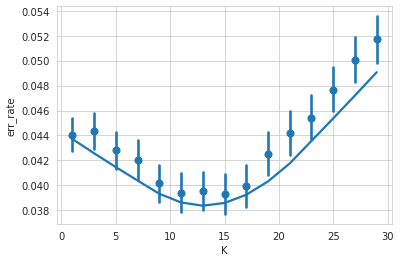

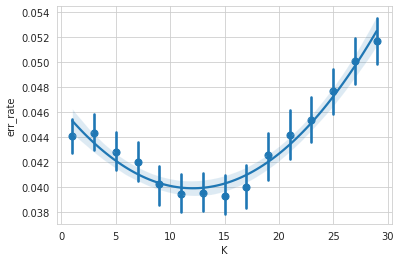

time: 37.5 s (started: 2021-10-25 22:27:18 +00:00)


In [140]:
iris_x = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])

ks = range(1, 30, 2)
results = []

for _ in tqdm(range(1000)):
# for _rep in tqdm(range(1000)):
    #TODO
    # Use np.random.randint to get training indices
    # The find all unselected indices to form a test set

    iris_sample_count = iris_x.shape[0]

    train_idx = np.random.randint(iris_sample_count, size=iris_sample_count)
    test_idx = ~np.isin(np.arange(iris_sample_count), train_idx, assume_unique=True)

    #TODO: apply your kNN classifier to data subset
    preds = KNN(iris_x[train_idx, :], iris_y[train_idx], iris_x[test_idx, :], ks=ks)
    errs = err_rates(preds, iris_y[test_idx])
    
    for k, errs_k in errs.items():
        results.append({'K':k, 'err_rate': errs_k})

# results_df will be a data_frame in long format
results_df = pd.DataFrame(results)

plt.figure()
sns.regplot(data=results_df, x='K', y='err_rate', x_estimator=np.mean, lowess=True)
plt.figure()
sns.regplot(data=results_df, x='K', y='err_rate', x_estimator=np.mean, order=2)


## Problem 4 kNN leave-one-out [2p]

Implement the k-NN algorithm with a leave-one-out error estimation 

**Hint**: except for couple of lines the code for the KNN_loo function is very much the same as in previous Problem

Then perform two experiments:
1. plot the leave-one-out error rate as a function of $K$
2. choose K=15, plot the leave-one-out error rate as a function of training dataset size. For best results, repeath the experiment 100 times with different permutations of the dataset.

In [8]:
def KNN_loo(train_X, train_Y, ks, limit=None, verbose=False):
#     Compute predictions for various k
#     Args:
#         train_X: array of shape Ntrain x D
#         train_Y: array of shape Ntrain
#         test_X: array of shape Ntest x D
#         ks: list of integers
#     Returns:
#         preds: dict k: predictions for k
#     """
    # Cast data to float32
    train_X = train_X.astype(np.float32)
    test_X = train_X

    if verbose:
        print("Computing distances... ", end='')
    #
    # TODO: fill in an efficient distance matrix computation
    # dists = np.sum(np.square(train_X[np.newaxis,:,:] - test_X[:, np.newaxis, :]), axis=(-1)) # slower
    dists = np.sum(np.square(test_X)[:, np.newaxis, :], axis=-1) - 2.0 * test_X.dot(train_X.T) + np.sum(np.square(train_X), axis=-1) # faster
    # who needs that sqrt thing when comparing l2 distances?

    dists[np.diag_indices(train_X.shape[0])] = np.Infinity # do not consider distances between pairs of the same elements

    if verbose:
        print("Sorting... ", end='')
    
    # TODO: find closest training points
    # Hint: use argsort
    closest = np.argsort(dists, axis=-1)
    del dists
    gc.collect()

    if verbose:
        print("Computing predictions...", end='')

    targets = train_Y[closest]

    preds = {}
    for k in ks:
        predictions = targets[:, :k]
        predictions = sstats.mode(predictions, axis=1)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    errs = err_rates(preds, train_Y)
    return preds, errs

time: 20.7 ms (started: 2021-10-26 20:12:43 +00:00)


In [142]:
ks = range(1, 30, 2)
iris_x = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
# iris_x = np.array(iris_df[['petal_length', 'petal_width']])
iris_y = np.array(iris_df['target'])
preds, errs = KNN_loo(iris_x, iris_y, ks)

time: 423 ms (started: 2021-10-25 22:32:36 +00:00)


,K,err_rate
0,1,0.040000
1,3,0.040000
2,5,0.033333
3,7,0.033333
4,9,0.040000
5,11,0.026667
6,13,0.033333
7,15,0.026667
8,17,0.026667
9,19,0.020000


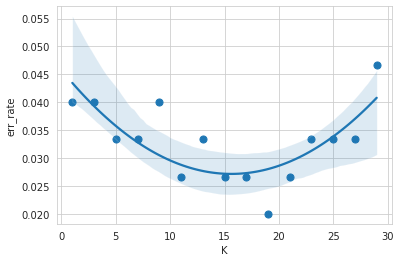

time: 937 ms (started: 2021-10-25 22:32:47 +00:00)


In [143]:
errs_df = pd.DataFrame(errs.items(), columns=['K', 'err_rate'])

plt.figure()
sns.regplot(data=errs_df, x='K', y='err_rate', x_estimator=np.mean, order=2)
# hmm I see some (minor?) deviations from the given exemplificatory plot

errs_df

  0%|          | 0/7 [00:00<?, ?it/s]

,trainset_size,err_rate
0,5,0.60
1,5,0.40
2,5,0.60
3,5,0.60
4,5,0.60
...,...,...
695,150,0.04
696,150,0.04
697,150,0.04
698,150,0.04


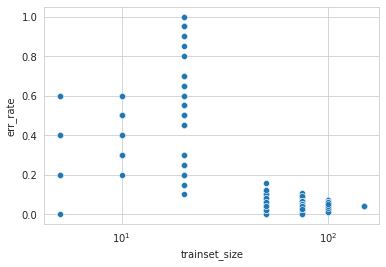

time: 44.7 s (started: 2021-10-26 20:14:59 +00:00)


In [17]:
k = 15
trainset_size_errs = []
for size in tqdm([5, 10, 20, 50, 75, 100, 150]):
    size_errs = []
    for _ in range(100):
        indices = np.random.choice(a=iris_x.shape[0], size=size, replace=False)
        x, y = iris_x[indices], iris_y[indices]
        _, err = KNN_loo(x, y, ks=[k])
        err = err[k]
        size_errs.append(err)
    trainset_size_errs.extend([(size, err) for err in size_errs])

trainset_size_errs_df = pd.DataFrame(trainset_size_errs, columns=['trainset_size', 'err_rate'])


plt.figure()
splot = sns.scatterplot(data=trainset_size_errs_df, x='trainset_size', y='err_rate')
splot.set(xscale="log")

trainset_size_errs_df

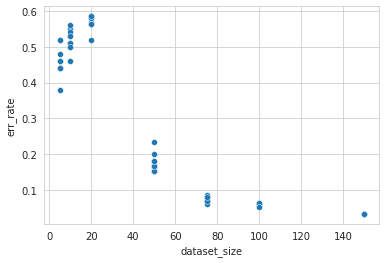

In [ ]:
plt.figure()
sns.scatterplot(data=trainset_size_errs_df, x='dataset_size', y='err_rate')

## Problem 5 kNN MNIST [2p] 

Apply the K-Nearest Neighbors (K-NN) algorithm to the MNIST dataset. 

The MNIST (http://yann.lecun.com/exdb/mnist/) dataset consists of normalized (centered and stretched) scans of hand-written digits. Specifically, each element of the dataset is a 28 × 28 grayscale image, thus having 764 8-bit pixels. 

1. Display a few objects from each of the classes, paying attention to aesthetics and clarity of your presentation. **Note:** You already downloaded the dataset in "Setup" section. Please use the code below to get started.

2. **[2p]** Apply a k-NN classifier to the MNIST dataset. First, divide the training set into two parts, which we will call training and validation. On MNIST use the first 50000 samples for training and the last 10000 for validation. Then find the optimal number of neighbors by assessing the accuracy on the validation set. You do not need to repeat this experiment multiple times. Finally, compute the accuracy on the test set obtained with the best previously chosen number of neighbors. On MNIST you should get about 3% errors. Pick a few mislabeled samples from the test dataset and plot them along with the correct ones. **Note:**
  * MNIST is much larger than the Iris dataset. A good implementation may need a few minutes depending on your runtime type. Please optimize your algorithm:
  * Compute the distances only once, then test for different values of k.
  * Use vectorized expressions to compute the distance. It is possible to compute all distances between the training and testing points in one expression. Hint: think about the vectorized expression \begin{equation}(X - Y)^T (X - Y)\end{equation}
  * You can use single precision numbers in computation.
  * If your code is taking a long time to execute, please save its results before the lab session.

**Note:** in NumPy, matrices have its own data type (dtype), which is retained during
calculations. Please pay attention to it. I particular, do not subtract values of data types not
having the sign bit, do not divide integers, etc. Results of such operations will not be
automatically casted to types having the required precision.

In [10]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

In [11]:
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
# debug = True
debug = False
if not debug:
    mnist_train_data_uint8 = mnist_full_train_data_uint8[:50000]
    mnist_train_labels_int64 = mnist_full_train_labels_int64[:50000]
    mnist_valid_data_uint8 = mnist_full_train_data_uint8[50000:]
    mnist_valid_labels_int64 = mnist_full_train_labels_int64[50000:]
else:
    _n = 2000
    mnist_train_data_uint8 = mnist_full_train_data_uint8[:_n]
    mnist_train_labels_int64 = mnist_full_train_labels_int64[:_n]
    mnist_valid_data_uint8 = mnist_full_train_data_uint8[_n:_n + _n]
    mnist_valid_labels_int64 = mnist_full_train_labels_int64[_n:_n + _n]

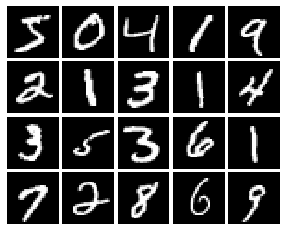

In [ ]:
# just to see how data looks like
plot_mat(mnist_train_data_uint8[:20, None], cmap='gray')

(20, 1, 28, 28)


4

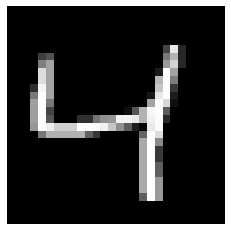

In [ ]:
# # just to see how data looks like
# print(mnist_train_data_uint8[:20, None].shape)
# digit, digit_label = mnist_full_train_data_uint8[2].reshape(-1, 28*28), mnist_train_labels_int64[2]
# plot_mat(digit.reshape(1, 1, 28, 28), cmap='gray')
# digit_label

In [145]:
# MNIST is large.
# Implement a batched KNN classifier, which processes the test data in small batches
# and returns the error rates

# The code should not run for more than a couple of minutes on the Colab runtime, 
# If it is slower, optimize the distance computation in KNN

def batched_KNN(train_X, train_Y, test_X, ks, verbose=False, batch_size=200):
    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        
        # TODO: run KNN on the batch and save the predictions
        batch_result = KNN(train_X, train_Y, batch_X, ks=ks, verbose=verbose)
        all_preds = {k: preds + [batch_result[k]] for k, preds in all_preds.items() }
    for k in all_preds.keys():
      # TODO: combine predictions from batches
      all_preds[k] = np.concatenate(all_preds[k])
    return all_preds


time: 9.4 ms (started: 2021-10-25 22:40:13 +00:00)


  0%|          | 0/50 [00:00<?, ?it/s]

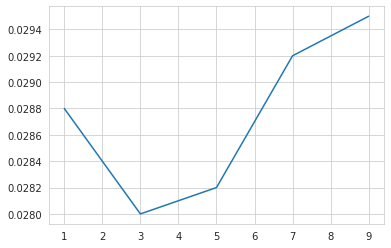

time: 1min 6s (started: 2021-10-25 22:40:18 +00:00)


In [146]:
# Now find the best k on the validation set
ks = [1, 3, 5, 7, 9]
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, batch_size=200)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [147]:
# Now use the best k to compute the test error

best_K = 3

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K],
    batch_size=20)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

  0%|          | 0/500 [00:00<?, ?it/s]



When k=3 the test error rate is 2.9%%
time: 2min 54s (started: 2021-10-25 22:42:33 +00:00)


### Mislabeled samples for the best k (equal to 3)

In [148]:
knn_labels = mnist_test_preds[best_K]
mislabeled_sample_indices = (knn_labels != mnist_test_labels_int64)
mislabeled_digit_to_present_count = 5*5
mislabeled_samples_data = mnist_test_data_uint8[mislabeled_sample_indices][:mislabeled_digit_to_present_count]
mislabeled_knn_labels = knn_labels[mislabeled_sample_indices][:mislabeled_digit_to_present_count]
mislabeled_real_labels = mnist_test_labels_int64[mislabeled_sample_indices][:mislabeled_digit_to_present_count]

time: 4.49 ms (started: 2021-10-25 22:45:29 +00:00)


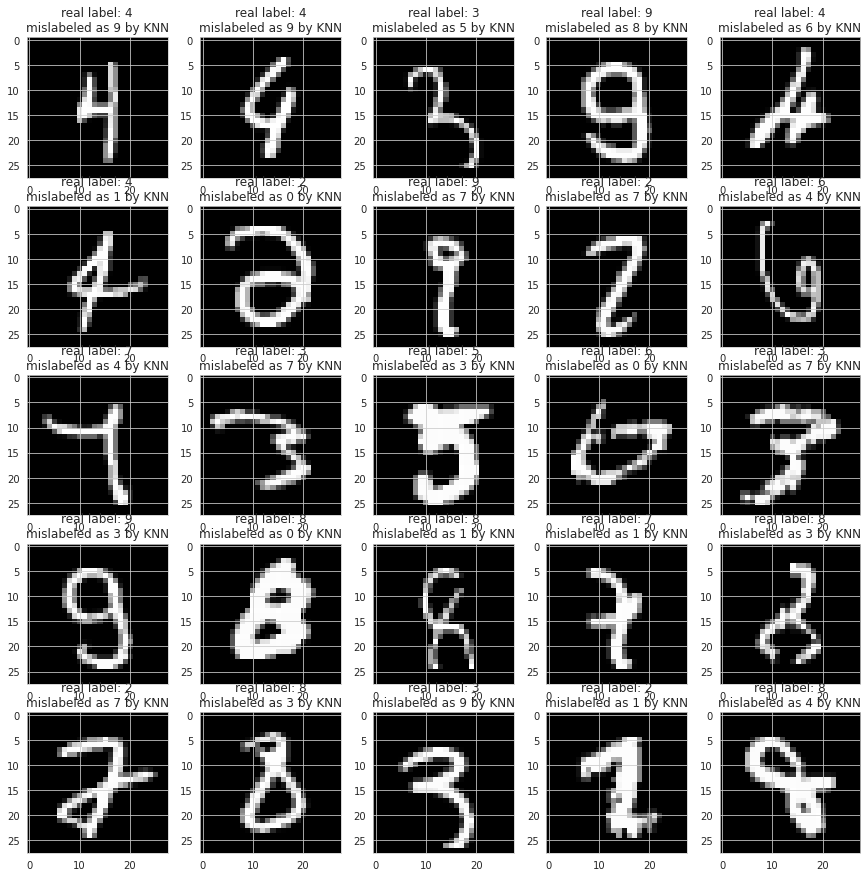

time: 5.48 s (started: 2021-10-25 22:45:29 +00:00)


In [149]:
fig = plt.figure(figsize=(15, 15))
fig.tight_layout(pad=20)
# fig.tight_layout()
i = 1
for digit_data, knn_label, real_label in zip(mislabeled_samples_data, mislabeled_knn_labels, mislabeled_real_labels):
    ax = fig.add_subplot(5, 5, i)
    plt.imshow(digit_data.reshape((28, 28)), cmap='gray')
    ax.title.set_text(f"real label: {real_label}\nmislabeled as {knn_label} by KNN")
    i += 1
plt.show()

## Problem 6 kNN cosine [2p]

In previous problems you've discovered how to compute nearest neighbors using Euclidian distance. However, Euclidian distance is not the only one that you can use. 

In Machine Learning very often we calculate similarity between vectors using the dot product or the correlation coefficient between them, which we can also call the cosine similarity. You will see this in Deep Learning class in Convolutional Neural Networks for Image Recognition tasks, and in Transformers for Natural Language Processing.

Let $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors. Their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.



To get an idea why it can work let us plot the correlation matrix for an ordered (according to the 0,1,...,9 labels) subset of the MNIST data.

In [150]:
X_subset = mnist_train_data_uint8[:2000].reshape((-1,28*28))
y_subset = mnist_train_labels_int64[:2000]

time: 3.94 ms (started: 2021-10-25 22:47:16 +00:00)


In [151]:
X_ordered = X_subset[np.argsort(y_subset)]
y_ordered = y_subset[np.argsort(y_subset)]

time: 9.37 ms (started: 2021-10-25 22:47:18 +00:00)


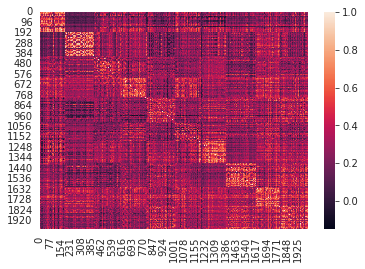

time: 5.86 s (started: 2021-10-25 22:47:23 +00:00)


In [152]:
import seaborn as sns

sns.heatmap(np.corrcoef(X_ordered))

You can see that squares at the diagonal are brighter. It's because these squares correspond to the vectors with the same labels.

### Implement your own correlation matrix computation [1p]

Instead of np.corrcoef implement your own computation of the correlation matrix. Again, it can be done without explicitely using for loops and using vectorization provided by NumPy.

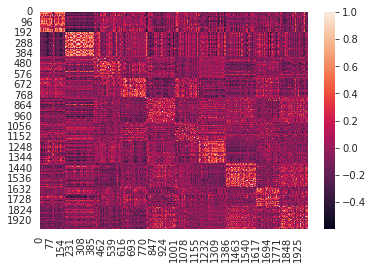

time: 5.85 s (started: 2021-10-25 22:47:39 +00:00)


In [153]:
#
# TODO: implement your own X_corr correlation matrix of X_ordered
#
def cov(X):
    N = X.shape[1]
    fact = N - 1
    X_mean_sub = X - X.mean(axis=0) # mean over observations (and not variables)
    return np.dot(X_mean_sub, X_mean_sub.T) / fact

def corrcoef(X):
    # the formula is as in numpy.corrcoef docs:
    # .. math:: R_{ij} = \\frac{ C_{ij} } { \\sqrt{ C_{ii} * C_{jj} } }
    # where C is covariance matrix
    C = cov(X)
    C_diag_sqrt = np.sqrt(np.diag(C))
    denominator = np.outer(C_diag_sqrt, C_diag_sqrt) # https://numpy.org/doc/stable/reference/generated/numpy.outer.html
    return C / denominator
    
X_corr = corrcoef(X_ordered)

sns.heatmap(X_corr)

### Implement kNN with leave-one-out [1p]

Implement kNN for a subset of the first 2000 rows of MNIST data (as X_ordered) with leave-one-out error estimation using the cosine similarity. Pick the best $k$.  (Note: if that helps you anyhow, you can use np.corrcoef here)

In [154]:
def KNN_loo_cosine(X_train, y_train, ks, verbose=False): # loo stands for leave one out
#   """
#   Compute predictions for various k
#   Args:
#       train_X: array of shape Ntrain x D # X_train really
#       train_Y: array of shape Ntrain
#       test_X: array of shape Ntest x D # is this actually here?
#       ks: list of integers
#   Returns:
#       preds: dict k: predictions for k
#   """
    X_train = X_train.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')
    #
    # TODO: fill in an efficient distance matrix computation

    norms = np.sqrt(np.einsum('ij,ij->i', X_train, X_train))
    # alternatively:
    # norms = np.linalg.norm(X_train, axis=-1, ord=2) # norms of each row; ord=2 means L2 norm

    X_train = X_train / norms[:, np.newaxis]
    del norms
    gc.collect()
    sims = (X_train[np.newaxis,:,:] * X_train[:, np.newaxis, :]).sum(axis=-1)
    gc.collect()
    sims[np.diag_indices(X_train.shape[0])] = -np.Infinity # similiarities[i, i] for i = 0,... = -inf, as we do not want to consider similiarity of data points with themselves
    # sims = sims / norms[np.newaxis, :] / norms[:, np.newaxis] # alternatively

    if verbose:
        print("Sorting... ", end='')
    
    # TODO: find closest training points
    # Hint: use argsort
    closest = np.argsort(-sims, axis=-1) # would be better to use argpartition as in code somewhere below
    # alternatively:
    # closest = np.flip(
    #     np.argsort(sims, axis=-1),
    #     axis=-1
    #     )

    if verbose:
        print("Computing predictions...", end='')

    targets = y_train[closest]
    del closest
    gc.collect()

    for k in ks:
        predictions = targets[:, 0:k]
        predictions = sstats.mode(predictions, axis=1)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    errs = err_rates(preds, y_train)
    return preds, errs

time: 30.9 ms (started: 2021-10-25 22:49:43 +00:00)


In [155]:
ks = range(3, 30, 2)
preds, errs = KNN_loo_cosine(X_ordered, y_ordered, ks)

time: 15.6 s (started: 2021-10-25 22:49:52 +00:00)


,K,err_rate
0,3,0.0835
1,5,0.0820
2,7,0.0890
3,9,0.0855
4,11,0.0910
5,13,0.0885
6,15,0.0915
7,17,0.0965
8,19,0.0995
9,21,0.1040


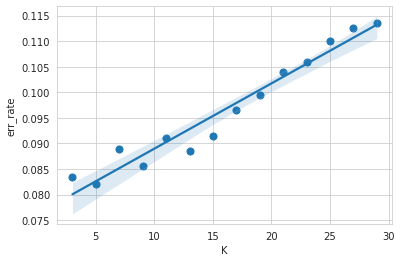

time: 1.12 s (started: 2021-10-25 22:50:24 +00:00)


In [156]:
errs_df = pd.DataFrame(errs.items(), columns=['K', 'err_rate'])

plt.figure()
sns.regplot(data=errs_df, x='K', y='err_rate', x_estimator=np.mean, order=1)

errs_df

### Implement batched kNN for MNIST [1p]

Now that you've implemented batched kNN for MNIST with Euclidian distance and LOO for kNN on MNIST with cosine distance, implement batched version of kNN for MNIST using cosine distance.
Use the same train/test/validation split as before, and compare the results.
Which distance metric is better?

(**Hint**: this time distances between train and valid sets cannot be computed using corrcoef, and you need to do it in a similar spirit as you did when you computed correlation matrix by hand. 

In [157]:
def KNN_cosine(X_train, y_train, test_X, ks, verbose=False):
#   """
#   Compute predictions for various k
#   Args:
#       X_train: array of shape Ntrain x D (assumed to be normalized)
#       y_train: array of shape Ntrain
#       test_X: array of shape Ntest x D (assumed to be normalized)
#       ks: list of integers
#   Returns:
#       preds: dict k: predictions for k
#   """
    X_train = X_train.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')

    # sims = (X_train[np.newaxis,:,:] * test_X[:, np.newaxis, :]).sum(axis=-1) # 9 times slower!! (so it can't multiply-accumulate and stores intermediate result!?)
    sims = test_X @ X_train.T # faster!!

    if verbose:
        print("Sorting... ", end='')
    
    # find most similar training points
    closest = np.argsort(-sims, axis=-1)
    # alternatively:
    # closest = np.flip(
    #     np.argsort(sims, axis=-1),
    #     axis=-1
    #     )

    if verbose:
        print("Computing predictions...", end='')

    targets = y_train[closest]
    del closest

    for k in ks:
        # predictions = targets[:, 0:k]
        predictions = sstats.mode(targets[:, 0:k], axis=1)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    return preds

time: 21.5 ms (started: 2021-10-25 22:52:40 +00:00)


In [158]:
# a batched KNN classifier with cosine distance, which processes the test data in small batches
def batched_KNN_cosine(X_train, y_train, test_X, ks, verbose=False, batch_size=200):
    # normalize vectors now instead of normalizing the computed similarities
    X_train_norms = np.sqrt((X_train * X_train).sum(axis=-1))
    # norms = np.linalg.norm(X_train, axis=-1, ord=2) # norms of each row; ord=2 means L2 norm
    X_train = X_train / X_train_norms[:, np.newaxis]
    del X_train_norms

    test_X_norms = np.sqrt((test_X * test_X).sum(axis=-1))
    # alternatively:
    # norms = np.linalg.norm(X_train, axis=-1, ord=2) # norms of each row; ord=2 means L2 norm
    test_X = test_X / test_X_norms[:, np.newaxis]
    del test_X_norms

    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        batch_result = KNN_cosine(X_train, y_train, batch_X, ks=ks, verbose=verbose)
        all_preds = {k: preds + [batch_result[k]] for k, preds in all_preds.items() }
    for k in all_preds.keys():
      all_preds[k] = np.concatenate(all_preds[k])
    return all_preds


time: 14.4 ms (started: 2021-10-25 22:52:58 +00:00)


In [159]:
# Now find the best k on the validation set
ks = [1, 3, 5, 7, 9]
ic.disable()
# ic.enable()
mnist_validation_preds = batched_KNN_cosine(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, batch_size=20)

  0%|          | 0/500 [00:00<?, ?it/s]

time: 1min 55s (started: 2021-10-25 22:53:00 +00:00)


{1: 0.0252, 3: 0.0249, 5: 0.0243, 7: 0.0261, 9: 0.0257}

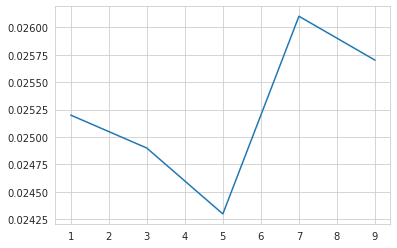

time: 348 ms (started: 2021-10-25 22:54:57 +00:00)


In [160]:
mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

mnist_validation_errs

In [161]:
# Now use the best k to compute the test error

best_K = 5

mnist_test_preds = batched_KNN_cosine(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K],
    batch_size=20)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

  0%|          | 0/500 [00:00<?, ?it/s]



When k=5 the test error rate is 2.7%%
time: 2min 16s (started: 2021-10-25 22:55:04 +00:00)


## Problem 7 kNN Locality Sensitive Hashing

In previous  using loops implicitly present in matrix multiplication instead of explicit loops in Python. In this problem, we will explore a strategy to truly reduce the total number of computations required to find nearest neighbors without sacrificing too much accuracy.

To speed up nearest neighbor search we will employ *Locality Sensitive Hashing (LSH)* functions. For a given distance metric, the locality sensitive hash should put items that are similar into the same bucket. Notice that this is essentially a design choice opposite to traditional cryptographic hash functions that should amplify the difference of similar inputs (typically we want that small perturbations of data result in large changes to the hash value).

One of the simplest implementations of LSH approximates is actually for the cosine similarity. Recall from the previous problem that when $x\in \mathbb{R}^N$ and $y\in \mathbb{R}^N$ be two vectors, then their cosine similarity is defined as:

\begin{equation}
    s_\text{cos}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \cos\left(\theta(x,y)\right),
\end{equation}
where $\theta(x,y)$ is the unsigned angle between $x$ and $y$.

We will construct a family $H$ of hash functions that are an LSH for angle distances (an approximation to cosine similarity). Assume $p\in \mathbb{R}^N$ is a random vector (components are sampled from the normal distribution) of length 1. Then define the hash function $h(x) = \text{sgn}(x\cdot p)$, where $\text{sgn()}$ is the sign function. It can be proven that:

\begin{equation}
    \mathbb{P}_{h\in H}[h(x)=h(y)] = 1 - \frac{\theta(x,y)}{\pi}.
\end{equation}

This hash function basically just says if vectors $x$ and $y$ are on the same side of the hyperplane orthogonal to $p$.
The equation means that the probability of a hash collision (or equivalently being on the same side of the hyperplane) grows as the the angle between two vectors gets smaller. Therefore, vectors that are close according to the cosine similarity will be put with high probability into the same bin (we use the fact that for small $\theta$ we can approximate $\cos(\theta) = 1 - \theta/\pi$.

### Amplification  

We can leverage the above observation by taking multiple hyperplanes. 
Suppose we have many hash functions $h_1,h_2,...,h_r$ from $H$, and we consider an amplified hash function $h = \left( h_1,h_2,...,h_r\right)$ (value of $h$ is a vector of functions' values). Show that [*the AND question*])

\begin{equation}
    \mathbb{P}_{h}[h(x)=h(y)] = \left(1 - \frac{\theta(x,y)}{\pi}\right)^r.
\end{equation}


What does it mean geometrically? For the purpose of these considerations we can assume that the vectors of MNIST digits lie on a sphere in 784 dimensions [*the WHY question*]. In three dimensions our hashing would look like this:

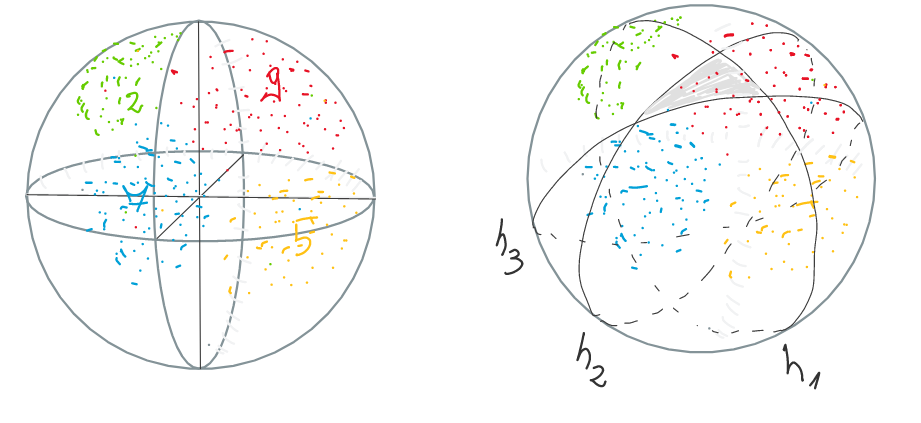

The amplified hash function represents the intersection of hyperplanes. And the intersection of hyperplanes define a cone. The grey area in the picture above is exactly the part of the sphere that belongs to a particular cone, i.e., the hash bucket.

### Speed up

Now the idea for the speed up is simple:
1. generate a random set of hash functions like the one above,
2. put each point in a bucket representing the cone
3. when classifying a point, don't look at all the points in the dataset, but only the points in the same cone.

This algorithm is randomized, so sometimes it can happen that for a given point the closest points with the same label will not end up in the same cone.
However, we can also amplify on this probability. If we will take $l$ independent divisions of the sphere into cones, and then for a given point we will scan all $l$ cones to which it belongs, then the probability that a very close (according to the cosine distance) point will not appear in none of them is very small. 

More formally, if $h^1 = (h^1_1,h^1_2,...,h^1_r), h^2 = (h^2_1,h^2_2,...,h^2_r),...,h^l = (h^l_1,h^l_2,...,h^l_r)$, then [*the OR question*]

\begin{equation}
\mathbb{P}_h^l \left[ h^1(x) = h^1(y) \vee h^2(x) = h^2(y) \vee ... \vee h^l(x) = h^l(y) \right] = 1 - \left(1-\left(1 - \frac{\theta(x,y)}{\pi}\right)^r\right)^l
\end{equation}


So the outline of the final algorithm should be like that
1. generate $l$ random sets of $r$ hash functions like the one above,
2. for each $h^i \in \left\{h^1,...,h^l \right\}$ put each point in a bucket representing its cone
3. when classifying a point, don't look at all the points in the dataset, but only the points in the same cones.

### Problem 7 [1-3p, 1 bonus point for Homework 1] 

1. **[1bp for exercises list]** **Note:** you can show sketches of proofs for this assignment.
    1. Show $d(x,y) = \theta(x,y)$ (angle between vectors) is a metric (https://en.wikipedia.org/wiki/Metric_(mathematics)). 
    Show example of why $d_{cos}(x,y) = 1- s_{cos}(x,y)=1-\cos \theta(x,y)$ is not a metric.
    
    2. Show that $p_{h\in H}[h(x)=h(y)] = 1 - \frac{\theta(x,y)}{\pi}$ for $h$ computed using a randomly chosen hyperplane.

    3. Answer the AND, OR and WHY questions from the problem statement.

  Please show the solution to this problem dirung the Session for Homework 1, the bonus point will also be added to the points from Homework 1.

3. **[1-3]** Reimplement k-Nearest Neighbors for MNIST classification using the cosine similarity instead of the Euclidean distance. Choose a sensible value of $k$. Use Locality Sensitive Hashing to achieve an error rate no greater than $150\%$ of the original error rate with at least a $90\%$ speedup (i.e., by considering on average at most 5000 training samples per query image). For a few settings plot the speedup-vs-accuracy relation.

  **Note:** points will be awarded based on ingenuity of your solution. Feel free to explore your own ideas!


### Problem 7.1 answers (pending)
#### 1. question answer
* *$d(x,y) = \theta(x,y)$ is a metric:* (I assume that smaller of two angles between vectors is meant here)
  * $d(x, y) \iff x = y$  
    By definition. If vectors are equal, then angle between them is 0. If angle between two vectors is 0, then they're equal if we consider only normalised vectors.
  * $d(x, y) = d(y, x)$  
    Angle between two vectors is symmetric function.
  * $d(x, y) \le d(x, z) + d(z, y)$  
    We still consifer unit length vectors only. There is no point in considering 3 vectors if some 2 of them are equal too (obvious equality then).
    * For 2D the property holds quite straightforward if you draw the vectors as points on the unit circle.  
    1st case: $z$ lies on the angle between $x$ and $z$, then LHS = RHS.  
    2nd case: $z$ lies outside, then we have LHS < RHS
    * For n-dimensional space the trick is as follows:  
      Vectors that have distance $d(x, y)$ from $x$ form a circle on unit hypersphere. You need to rearrange the inequality with vectors that are on a circle on the unit hypershpere.

* The $d_{cos}(x,y) = 1 - \cos \theta(x,y) $ metric candidate is not a metric*  
  It does not fulfill triangle equality criterion. Counterexample:  
  Let $v_1 = (0, 1)$; $v_2 = (\sqrt{2} / 2, \sqrt{2} / 2)$; $v_3 = (1, 0)$.  
  Then:  
  $\theta(v_1, v_2) = \theta(v_2, v_3) = \pi / 2$ and $\theta(v_1, v_3) = \pi$  
  $d(v_1, v_2) = d(v_2, v_3) = 1 - \cos(\pi / 2) = 1 - \sqrt{2}/2 $ and $d(v_1, v_3) = 1 - \cos(\pi) = 1 - 0 = 1$  

$$ d(v_1, v_3) \stackrel{?}{\le} d(v_1, v_2) + d(v_2, v_3) $$
$$ 1 \stackrel{?}{\le} 2 - \sqrt{2} $$
$$  \sqrt{2} {\nleq} 1$$

#### 2. question answer

$p_{h\in H}[h(x) \neq h(y)] = \frac{2 \theta(x,y)}{2\pi} = \text{chance that } p \text{ lies in angle between } x \text{ and } y \text { or a corresponding oposite vertical angle} = \frac{\theta(x,y)}{\pi}$  
Thus $p_{h\in H}[h(x)=h(y)] = 1 - \frac{\theta(x,y)}{\pi}$ whe $h$ hashes using single $p$ vector.

#### 3. question answers

##### **And question answer**

$\mathbb{P}_{h}[h(x)=h(y)] = \left(1 - \frac{\theta(x,y)}{\pi}\right)^r$ when $h = (h^1_1,h^1_2,...,h^1_r)$, because we need $r$ independent events to occur and each of them has a probability shown in answer above.

##### **Or question answer**

*Why is $$\mathbb{P}_h^l \left[ h^1(x) = h^1(y) \vee h^2(x) = h^2(y) \vee ... \vee h^l(x) = h^l(y) \right] = 1 - \left(1-\left(1 - \frac{\theta(x,y)}{\pi}\right)^r\right)^l$$?*

Because  
$$\mathbb{P}_h^l \left[ h^1(x) = h^1(y) \vee h^2(x) = h^2(y) \vee ... \vee h^l(x) = h^l(y) \right] = 1 - \mathbb{P}_h^l \left[ h^1(x) \neq h^1(y) \wedge h^2(x) \neq h^2(y) \vee ... \vee h^l(x) \neq h^l(y) \right] = \text{some compliment and independent events juggling ommited}$$

##### **Why question answer**

*What does the probability of hash collision when hashing with single set of $r$ $p$ vectors mean geometrically?*

For $r=1$ probability that diameter will be included in the angle between $x$ and $y$.  
For $1 < r$ probability that line going through the origin of hyperplane will go through cone on hypersphere defined by the given hash.


### Problem 7.2 answers

In [133]:
# fetch some fancy shmancy profiler
!pip install line_profiler
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
time: 3.07 s (started: 2021-10-25 22:20:16 +00:00)


#### $l$ random sets of $r$ hash -- too slow, not used, go to the next header

In [69]:
def hash_vectors(ps, xs):
    return np.packbits(
        0 < ((ps[np.newaxis, :] * xs[:, np.newaxis, :]).sum(axis=-1)),
        axis=-1
    ).ravel()

In [64]:
from collections import defaultdict

In [72]:
def KNN_lsh(X_train, y_train, test_X, ks, verbose=False):
    all_preds = {k: [] for k in ks}
    max_k = max(ks)
    X_train = X_train.astype(np.float32)
    test_X = test_X.astype(np.float32)
    # normalize vectors now instead of normalizing the computed similarities
    # X_train_norms = np.sqrt((X_train * X_train).sum(axis=-1)) # slow
    X_train_norms = np.sqrt(np.einsum('ij,ij->i', X_train, X_train)) # fast
    X_train = X_train / X_train_norms[:, np.newaxis]
    del X_train_norms

    # normalize test vectors too
    # test_X_norms = np.sqrt((test_X * test_X).sum(axis=-1)) # slow
    test_X_norms = np.sqrt(np.einsum('ij,ij->i', test_X, test_X)) # fast
    test_X = test_X / test_X_norms[:, np.newaxis]
    del test_X_norms
    
    # p_count = 8
    # p_count = 2
    p_count = 8 # this is r from the problem statement
    assert p_count <= 8, "it cannot be handled as numpy.packbits handles uint8 only"
    p_set_count = 3 # this is l from the problem statement
    ps_set = tuple(np.random.randn(p_count, X_train.shape[-1]) for _ in range(p_set_count)) # the first is number of p vectors, the latter is data point length
    ps_set = tuple(ps / np.linalg.norm(ps, ord=2, axis=-1)[:, np.newaxis] for ps in ps_set)

    X_train_hash2idxs = [defaultdict(list) for _ in range(p_set_count)]
    for i in range(p_set_count):
        for idx, datapoint_hash in enumerate(hash_vectors(ps_set[i], X_train)):
            X_train_hash2idxs[i][datapoint_hash].append(idx)

    X_train_hash2idxs = tuple( # converts lists to np.arrays; not needed?
                         defaultdict(lambda: np.array([], dtype=int), { hash: np.hstack(indices) for hash, indices in hash_indices.items() }) # we need default dict, because sometimes a hash can be queried that we do not have in train_X
                         for hash_indices in X_train_hash2idxs
    )

    test_X_hashes = tuple(
                     hash_vectors(ps, test_X)
                     for ps in ps_set
    )

    targets = []

    for test_item_i in tqdm(range(test_X.shape[0])):
        test_item = test_X[test_item_i]

        test_item_hashes = tuple(
                test_X_hashes[ps_set][test_item_i]
                for ps_set in range(p_set_count)
            )
        same_hash_train_indices = np.unique(
            np.concatenate(
              tuple(
                  X_train_hash2idxs[hash_set_i][hash]
                for hash_set_i, hash in enumerate(test_item_hashes)
                )
            )
        )

        test_item_sims = X_train[same_hash_train_indices] @ test_item.T

        closest_indices = np.argpartition(-test_item_sims, kth=max_k, axis=-1)[:max_k] # all in all no need to use argsort; will use argpartition instead
        
        test_item_targets = y_train[same_hash_train_indices[closest_indices]]
        targets.append(test_item_targets)
            
    targets = np.vstack(targets)
    
    all_preds = { k: sstats.mode(targets[:, 0:k], axis=1).mode.ravel() for k in ks }
    return all_preds


In [73]:
# debug for testing vectorized hashing
ks = [1, 3, 5, 7, 9]

mnist_validation_preds = KNN_lsh(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
# profiling
%prun KNN_lsh(mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64, mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28), ks, batch_size=20)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
# almost no performance drop :)
mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
mnist_validation_errs


{1: 0.0432, 3: 0.0367, 5: 0.0374, 7: 0.0391, 9: 0.0421}

{1: 0.0432, 3: 0.0367, 5: 0.0374, 7: 0.0391, 9: 0.0421}

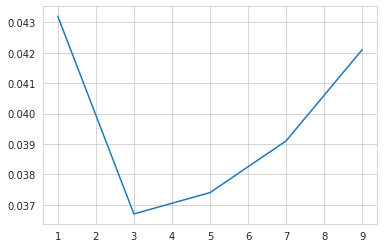

In [46]:
mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

mnist_validation_errs

In [162]:
# Now use the best k to compute the test error

best_K = 3

mnist_test_preds = KNN_lsh(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K],
    batch_size=20)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

  0%|          | 0/10000 [00:00<?, ?it/s]



When k=3 the test error rate is 3.5%%
time: 1min 31s (started: 2021-10-25 22:57:50 +00:00)


#### the same as above rewritten without many random sets of hash functions -- good enough

Now inference does not need to compute similarities looping over test_X vectors.  
Instead it loops over test_X hashes and computes similarities for all vectors with the same hash at once thus benefiting from built-in NumPy vectorization

In [169]:
# don't waste time on ps_sets
# benefit from vectorization with just one set of p vectors
# profit

def KNN_lsh_2nd_try(X_train, y_train, test_X, ks, verbose=False):
    all_preds = {k: [] for k in ks}
    max_k = max(ks)
    X_train = X_train.astype(np.float32)
    test_X = test_X.astype(np.float32)
    # normalize vectors now instead of normalizing the computed similarities
    X_train_norms = np.sqrt(np.einsum('ij,ij->i', X_train, X_train)) # fast
    X_train = X_train / X_train_norms[:, np.newaxis]
    del X_train_norms

    # normalize test vectors too
    # test_X_norms = np.sqrt((test_X * test_X).sum(axis=-1)) # slow
    test_X_norms = np.sqrt(np.einsum('ij,ij->i', test_X, test_X)) # fast
    test_X = test_X / test_X_norms[:, np.newaxis]
    del test_X_norms
    
    p_count = 3 # this is r from the problem statement
    # p_count = 5 # OSTROŻNIE (i am not kidding, this produces too small buckets for large k-s)
    assert p_count <= 8, "it cannot be handled as numpy.packbits handles uint8 only"
    ps = np.random.randn(p_count, X_train.shape[-1]) # the first is number of p vectors, the latter is data point length
    ps /= np.linalg.norm(ps, ord=2, axis=-1)[:, np.newaxis] # all in all no need to normalize (?)

    X_train_hash2idxs = defaultdict(list)
    for idx, datapoint_hash in enumerate(hash_vectors(ps, X_train)):
        X_train_hash2idxs[datapoint_hash].append(idx)

    # converts lists to np.arrays; not needed? todo: just call np.array instead of np.hstack
    X_train_hash2idxs = defaultdict(lambda: np.array([], dtype=int), { hash: np.hstack(indices) for hash, indices in X_train_hash2idxs.items() }) # we kinda need default dict, because sometimes a hash can be queried that we do not have in train_X

    X_test_hash2idxs = defaultdict(list)
    for idx, datapoint_hash in enumerate(hash_vectors(ps, test_X)):
        X_test_hash2idxs[datapoint_hash].append(idx)

    X_test_hash2idxs = defaultdict(lambda: np.array([], dtype=int), { hash: np.hstack(indices) for hash, indices in X_test_hash2idxs.items() }) # we kinda need default dict, because sometimes a hash can be queried that we do not have in train_X

    targets = [None for _ in test_X]

    for hash in tqdm(X_test_hash2idxs):
        hash_test_indices = X_test_hash2idxs[hash]
        hash_test_items = test_X[hash_test_indices]
        same_hash_train_indices = X_train_hash2idxs[hash]
        same_hash_train_items = X_train[same_hash_train_indices]

        sims = hash_test_items @ same_hash_train_items.T # (test items count) x (train items count)
        # closest_indices = np.argsort(-sims, axis=-1)[:, :max_k]
        closest_indices = np.argpartition(-sims, kth=max_k, axis=-1)[:, :max_k] # early optimisation is the root of all evil
        test_items_targets = y_train[same_hash_train_indices[closest_indices]]
        for test_X_item_idx, test_X_item_targets in zip(hash_test_indices, test_items_targets):
            targets[test_X_item_idx] = test_X_item_targets
            
    targets = np.vstack(targets)
    
    all_preds = { k: sstats.mode(targets[:, 0:k], axis=1).mode.ravel() for k in ks }
    return all_preds


time: 60.6 ms (started: 2021-10-25 23:01:10 +00:00)


In [6]:
!pip install ipython-autotime

%load_ext autotime

time: 134 µs (started: 2021-10-26 20:09:48 +00:00)


In [176]:
# Now find the best k on the validation set
ks = [1, 3, 5, 7, 9]
ic.disable()
mnist_validation_preds = KNN_lsh_2nd_try(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks)

# as supposed for l = 3 this is approx. 8 (2^3) times faster than a version without buckets

  0%|          | 0/8 [00:00<?, ?it/s]

time: 5.57 s (started: 2021-10-25 23:03:08 +00:00)


{1: 0.0546, 3: 0.0441, 5: 0.0423, 7: 0.0424, 9: 0.0426}

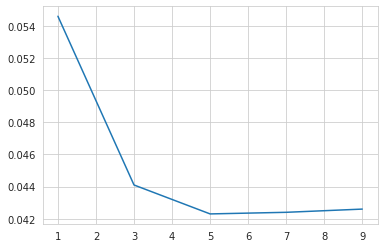

time: 342 ms (started: 2021-10-25 23:03:14 +00:00)


In [177]:
# goal: at most 0.04395 error rate (150% of initial)
# this run is not cherry-picked
# need to benchmark by running multiple times
mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

mnist_validation_errs

In [179]:
# Now use the best k to compute the test error
# this run is not cherry-picked
# got approx. 120 s -> 9 s run time
# need to benchmark by running multiple times

best_K = 5

mnist_test_preds = KNN_lsh_2nd_try(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K]
    )

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%%")

  0%|          | 0/8 [00:00<?, ?it/s]



When k=5 the test error rate is 3.4%%
time: 8.93 s (started: 2021-10-25 23:05:08 +00:00)
